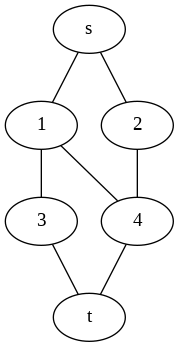

In [1]:
import pydotplus
from IPython.display import Image, display
start_end = ('s','t')
graph = pydotplus.Dot(graph_type='graph')
nodes = [start_end[0], start_end[1]] + [str(i) for i in range(1, 5)]
for node in nodes:
    graph.add_node(pydotplus.Node(node,fillcolor="red"))
edges = [(start_end[0], 1), (start_end[0], 2), (1, 3), (1, 4), (2, 4), (3, start_end[1]), (4, start_end[1])]
for edge in edges:
    graph.add_edge(pydotplus.Edge(str(edge[0]), str(edge[1])))
display(Image(graph.create_png()))

### Problem 1
#### Problem definition
Assume that forming a path connecting s and t leads to a reward of \$100. Then, compute the
Shapley value associated with the agents in $\{1,2,...,n\}$ as a fair way to distribute that reward among
the agents in $\{1,2,...,n\}$, which in particular encourages cooperation.


In [2]:
from math import factorial
from itertools import combinations

def powerset(list: list):
    subsets = [frozenset(j) for i in range(len(list) + 1) for j in combinations(list, i)]
    return subsets

def __exists_path_via_nodes(graph: pydotplus.Dot, start_node: str, end_node: str):
    visited = set()
    queue = [start_node]

    while queue:
        current_node = queue.pop(0)
        if current_node == end_node:
            return True
        if current_node not in visited:
            visited.add(current_node)
            for edge in graph.get_edge_list():
                if edge.get_source() == current_node:
                    queue.append(edge.get_destination())
    return False

def exists_path_between_s_and_t_after_delete(graph: pydotplus.Dot, nodes_to_delete: frozenset):
    nodes = [start_end[0], start_end[1]] + [str(i) for i in range(1, 5)]
    new_nodes = []
    for node in nodes:
      if node in list(nodes_to_delete):
        new_nodes.append(node)
    edges = [(start_end[0], 1), (start_end[0], 2), (1, 3), (1, 4), (2, 4), (3, start_end[1]), (4, start_end[1])]
    new_edges = []
    for edge in edges:
      if edge[0] in list(nodes_to_delete) or edge[1] in list(nodes_to_delete):
        new_edges.append(edge)
    pruned = pydotplus.Dot(graph_type='graph')
    for node in new_nodes:
      pruned.add_node(pydotplus.Node(node))
    for edge in new_edges:
      pruned.add_edge(pydotplus.Edge(str(edge[0]), str(edge[1])))
    #Uncomment this line below if you want to plot the pruned_graph
    #display(Image(pruned_graph.create_png()))
    return __exists_path_via_nodes(pruned,start_end[0],start_end[1])


def exam_characteristic_function(graph: pydotplus.Dot, coalition: frozenset):
    return 100 if exists_path_between_s_and_t_after_delete(graph, coalition) else 0

In [3]:
g_nodes = nodes.copy()
g_nodes.remove(start_end[0])
g_nodes.remove(start_end[1])
g_nodes = list(map(int,g_nodes))

In [4]:
def get_characteristic_function(graph, graph_nodes: frozenset, coalition, check_path, characteristic_function):
    if coalition in characteristic_function:
        return
    characteristic_function[coalition] = exam_characteristic_function(graph, coalition) if check_path else 100
    check_path = False if characteristic_function[coalition] == 100 else True
    graph_nodes_without_coalition = graph_nodes.difference(coalition)
    supersets = [coalition.union([j]) for j in graph_nodes_without_coalition]
    for c in supersets:
        get_characteristic_function(graph, graph_nodes, c, check_path, characteristic_function)


characteristic_function = {}
get_characteristic_function(graph, frozenset(g_nodes), frozenset([]), True, characteristic_function)
print("Characteristic function")
for key, value in characteristic_function.items():
    print(f"{list(key)}: {value}")

Characteristic function
[]: 0
[1]: 0
[1, 2]: 0
[1, 2, 3]: 100
[1, 2, 3, 4]: 100
[1, 2, 4]: 100
[1, 3]: 100
[1, 3, 4]: 100
[1, 4]: 100
[2]: 0
[2, 3]: 0
[2, 3, 4]: 100
[2, 4]: 100
[3]: 0
[3, 4]: 0
[4]: 0


In [5]:
def shapley_value(player, characteristic_function):
    player_list = max(characteristic_function)
    player = set([player])
    N = len(player_list)
    coalitions = powerset(player_list)
    shapley_val = 0
    for coalition in coalitions:
        if len(coalition) != 0:
            S = len(coalition)
            marginal_contribution = characteristic_function[coalition] - (characteristic_function[coalition - player] if len(coalition - player) > 0 else 0)
            shapley_val += ((factorial(N - S) * factorial(S - 1)) / factorial(N)) * marginal_contribution
    return shapley_val

def shapley(characteristic_function):
    return {player: shapley_value(player, characteristic_function) for player in max(characteristic_function)}

print("** Shapley values **")
shapley_values = shapley(characteristic_function).items()
for key, value in shapley_values:
    print(f"Player {key} -> {value:.2f}")

** Shapley values **
Player 1 -> 33.33
Player 2 -> 16.67
Player 3 -> 16.67
Player 4 -> 33.33


### Problem 2
#### Problem definition
Assume that each agent in $\{1,2…,n\}$ might freely decide whether to provide her/his contribution to connect $s$ and $t$. Assume, in particular, that each agent is willing to contribute only if at most two of her/his neighbours do so. Then, check whether the resulting setting admits a pure Nash equilibrium and compute one, if any.


In [6]:
def find_neighbors(graph,target_node_name):
  target_node = None
  for node in graph.get_nodes():
      if str(node.get_name()) == target_node_name:
          target_node = node
          break
  if target_node:
      neighbors = []
      for edge in graph.get_edges():
          if edge.get_source() == target_node.get_name():
            neighbors.append(edge.get_destination())
          if edge.get_destination() == target_node.get_name():
            neighbors.append(edge.get_source())
      return neighbors

In [7]:
def check_nash_equilibrium(graph, players, action_profile: dict):
    for player in players:
        sum_ns = 0
        for neighbor in find_neighbors(graph, str(player)):
            if neighbor.isdigit():
                if action_profile[int(neighbor)] == "y":
                  sum_ns+=1
            else:
              if action_profile[neighbor] == "y":
                sum_ns += 1
        if action_profile[player] == 'y' and sum_ns > 2:
          return False
        if action_profile[player] == 'n' and sum_ns <= 2:
          return False
    return True

def find_nash_equilibrium(graph, players: list, action_profile: dict, i=0):
    for c in range(2):
        c2 = ""
        c2 = "y" if c == 1 else "n"
        action_profile[players[i]] = c2
        if i == len(players) - 1:
            if check_nash_equilibrium(graph, players, action_profile):
                return action_profile
        elif find_nash_equilibrium(graph, players, action_profile, i + 1) is not None:
            return action_profile
    return None


equilibrium = find_nash_equilibrium(graph, g_nodes, {start_end[0]: 'y', start_end[1]: 'y'})
print(equilibrium)

if equilibrium is not None:
    print("N.E found:")
    for key, value in equilibrium.items():
        if key not in start_end:
          print(f"Player {key} {'contributes' if value=='y' else 'does not contribute'}")
else:
    print("N.E not found")


{'s': 'y', 't': 'y', 1: 'n', 2: 'y', 3: 'y', 4: 'y'}
N.E found:
Player 1 does not contribute
Player 2 contributes
Player 3 contributes
Player 4 contributes


### Problem 3
#### Problem definition
Assume that G has treewidth bounded by some constant and provide again answer to point 2, by exploiting this additional information.

#### Solution
With the newfound understanding that the graph possesses bounded treewidth, we can leverage Courcelle's theorem, which posits that any problem formulated within Monadic Second Order Logic (MSO) on graphs of bounded treewidth can be resolved in linear time.

By capitalizing on this theorem, we can articulate the second point (\ref{sec:nash} {Nash Equilibrium}) in Monadic Second Order Logic to establish the existence of an algorithm capable of resolving the problem within linear time complexity.

**MSO Formulation for Nash Equilibrium Verification**

**Step 1: Definition of Node Sets**

Let $V$_0 and $V$_1  be two sets of nodes defined as follows:

V0 = {v ∈ N | (deg(v) ≤ 2) ∧ (σ(v) = 0)}
V1 = {v ∈ N | (deg(v) > 2) ∧ (σ(v) = 1)}



**Step 2: Formulation of Conditions in MSO**

We use second-order quantification to express the conditions in MSO. The MSO formula is as follows:

**Condition 1: No agent changes action if the number of contributing neighbors is greater than 2**


∀v ∈ A [ (v ∈ V0 ∧ ∀u ∈ N (v) (u /∈ V1))
∨ (v ∈ V1 ∧ ∀u ∈ N (v) (u ∈ V1)) ]

**Condition 2: All agents follow this condition**

∀v ∈ A ∀u ∈ N (v) [ (u ∈
V0 ∧ ∀w ∈ N (u) (w /∈ V1))
∨ (u ∈ V1 ∧ ∀w ∈ N (u) (w ∈ V1)) ]


These formulations express the necessary conditions for an action profile to be a Nash equilibrium in the graph using second-order quantification in monadic second-order logic (MSO), with a clear definition of node sets and the use of second-order quantification for the conditions.

Here's a breakdown of how the formulas adhere to MSO principles:

1. **Node Sets**
    - The formulas define two sets of nodes, V0 and V1, using first-order logic over the set of nodes N.
    - This aligns with MSO, which allows quantification over sets of elements in the domain.

2. **Second-Order Quantification**
    - The conditions for Nash equilibrium are expressed using second-order quantification over sets of nodes.
    - This is a key feature of MSO, enabling statements about relationships between sets of elements.

3. **Restriction to Monadic Quantification**
    - The quantification is restricted to sets of nodes, not relations or functions.
    - This adheres to the monadic nature of MSO, which only permits quantification over sets.

4. **Expressing Graph Properties**
    - The formulas capture properties of the graph, such as node degrees and relationships between neighboring nodes.
    - MSO is well-suited for expressing graph properties due to its ability to quantify over sets of nodes and edges.

5. **Capturing Nash Equilibrium Conditions**
    - The formulas successfully express the necessary conditions for an action profile to be a Nash equilibrium in the graph.
    - This demonstrates the expressive power of MSO in formulating strategic complexity.


### Problem 4
#### Problem definition
Assume that agent $i$ in $\{1,2,...,n\}$ has some internal utility – say $i * 10\$$ – for being selected in a path
connecting $s$ and $t$, and that s/he might cheat in declaring a different utility. Assume moreover that
the goal is to form a path with the maximum overall possible utility, and compute a payment scheme
that provides incentives to truthfully report such utility values.


In [8]:
def find_all_simple_paths(graph, start, end, path=[]):
    path = path + [start]
    if start == end:
        return [path]
    # Check if the start node is in the graph
    if start in graph.obj_dict['nodes']:
        paths = []
        for edge in graph.get_edge_list():
            src, dest = edge.get_source(), edge.get_destination()
            if src == start and dest not in path:
                new_paths = find_all_simple_paths(graph, dest, end, path)
                for new_path in new_paths:
                    paths.append(new_path)
        return paths
    else:
        return []

paths = find_all_simple_paths(graph, start_end[0],start_end[1])
print(paths)

[['s', '1', '3', 't'], ['s', '1', '4', 't'], ['s', '2', '4', 't']]
[['s', '1', '3', 't'], ['s', '1', '4', 't'], ['s', '2', '4', 't'], ['1', '2', '3', '4', 's', 't']]


In [ ]:
#"additional_path" it's simply the path that contains all the nodes in the graph. Obviously a sure path from 's' to 't' is the path which contains all the nodes.
additional_path = [str(g) for g in g_nodes]
additional_path.extend([start_end[0], start_end[1]])
paths.append(additional_path)
print(paths)

In [9]:

def utility(node,cost):
    if cost==10:
      return node * cost
    return cost

def find_best_result(paths,cost):
    best_result = 0
    best_path = []
    for path in paths:
        result = sum(utility(int(node),cost) for node in path if node not in start_end)
        if result > best_result:
            best_result = result
            best_path = path
    return best_result, best_path

def find_best_result_excluding_player(paths, excluded_player,cost):
    best_result = 0
    for path in paths:
        if str(excluded_player) not in path:
            result = sum(utility(int(node),cost) for node in path if node not in start_end)
            best_result = max(result, best_result)
    return best_result

def estimate_payment(best_result, best_path, player,cost):
    result_player = best_result - utility(player,cost) if str(player) in best_path else best_result
    result_excluding_player = find_best_result_excluding_player(paths, player,cost)
    return result_excluding_player - result_player



In [10]:
prooves = (10,500)
for p in prooves:
  best_result, best_path = find_best_result(paths,p)
  print("Payments:")
  for node in g_nodes:
      print(f"Payment of player {node}: {estimate_payment(best_result, best_path, node,p)}")

  print("*"*len("Payment of player # :    "))


Payments:
Payment of player 1: -30
Payment of player 2: -30
Payment of player 3: -10
Payment of player 4: -20
*************************
Payments:
Payment of player 1: -500
Payment of player 2: -500
Payment of player 3: -500
Payment of player 4: -500
*************************
